# DeNAPoseを使ってパラメータ取得

## モジュール読み込み

In [1]:
# モジュール更新の際にオートリロード
%load_ext autoreload
%autoreload 2

In [3]:
# 画像処理・出力
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ディレクトリ探索・その他デバッグ
import os
import sys

# 特徴量抽出
from DeNAPose.hand_detector import HandDetector, draw_hand_keypoints
from DeNAPose.pose_detector import PoseDetector
from HandTracking.utils import detector_utils

# 特徴量作成
import pandas as pd

# for文の進捗管理用
from tqdm import tqdm_notebook as tqdm

# 1枚の静止画に対してパラメータを取得

##  データセットの読み込み

In [3]:
# データセットは藤井七段の対局を中心に6局程度
!ls /media/nvidia/ST_SD32G/data/

fujii_vs_takami_semi_1.mov  hashimoto_vs_fujii_Ablock2_1.mov
fujii_vs_takami_semi_2.mov  masuda_vs_fujii_semi2_1.mov
fujii_vs_takami_semi_3.mov  masuda_vs_fujii_semi2_2.mov


In [4]:
cap = cv2.VideoCapture("/media/nvidia/JetsonTX2SSD240/data/AbemaTV_Tournament_Final1.mp4")

## モデルの読み込み

In [5]:
pose_detector = PoseDetector("posenet", "../utils/DeNAPose/models/coco_posenet.npz", device=0)
hand_detector = HandDetector("handnet", "../utils/DeNAPose/models/handnet.npz", device=0)

Loading the model...
Loading HandNet...


In [6]:
detection_graph, sess = detector_utils.load_inference_graph()

> ====== loading HAND frozen graph into memory
>  ====== Hand Inference graph loaded.


## 体や手の検出とスケルトン取得

### 動画から1枚画像を読み込む

In [10]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
#frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)

In [11]:
frame.shape

(1080, 1920, 3)

### 将棋盤の検出(条件を絞る)
データの大体中央に位置するためそこから大まかにX軸を絞っていく

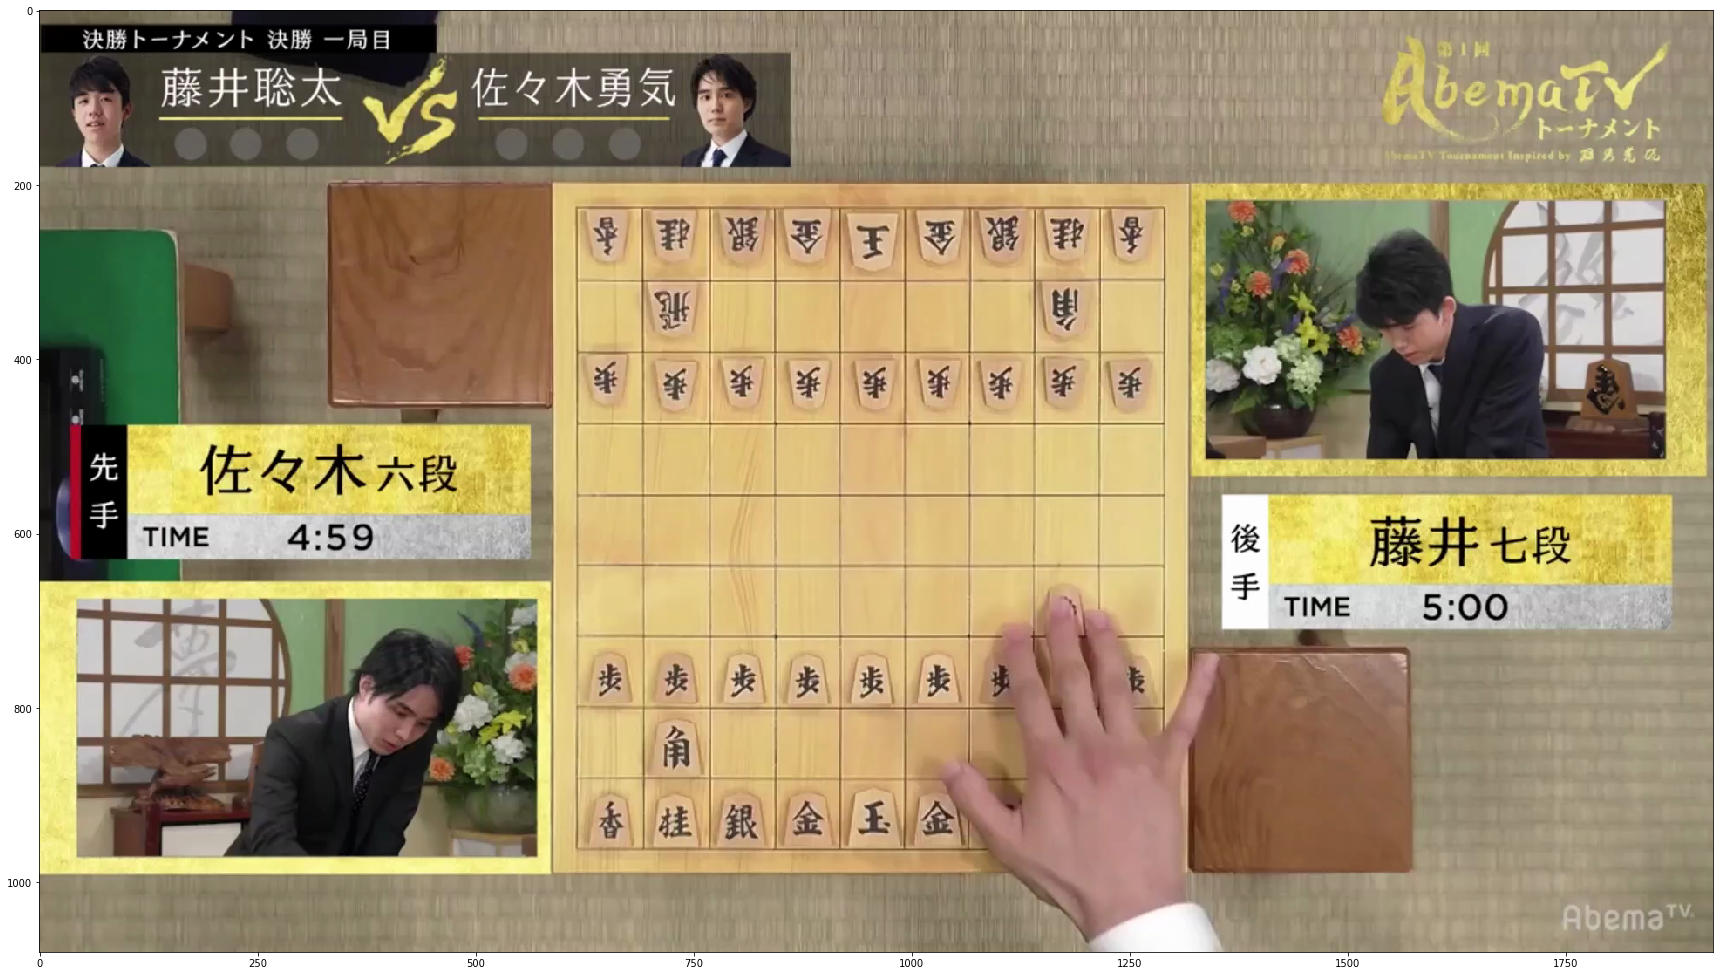

In [12]:
plt.figure(figsize=(30,18))
plt.imshow(frame)

In [254]:
# 手を検出する範囲をパワーコーディングしていく
field = frame[:, 500:2755].copy()
_ = cv2.rectangle(field, (0, 800), (500, field.shape[0]), (0, 0, 0), -1)
_ = cv2.rectangle(field, (field.shape[1]-450, 0), (field.shape[1], field.shape[0]-650), (0, 0, 0), -1)

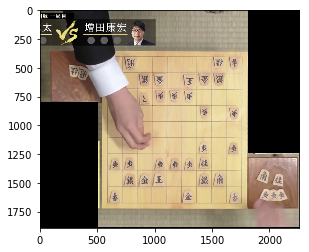

In [255]:
plt.imshow(field)

### 体の検出

In [256]:
body_black = frame[1130:1730, 0:1000].copy()

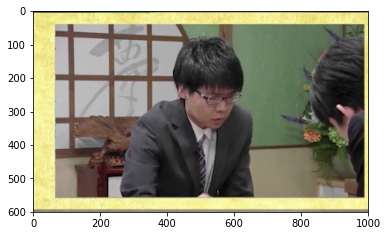

In [257]:
plt.imshow(body_black)

In [258]:
body_white = frame[350:950, 2300:frame.shape[1]]

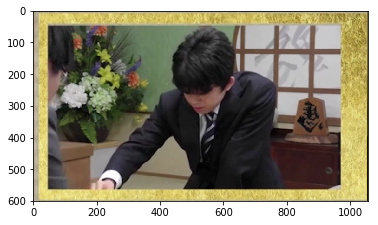

In [259]:
plt.imshow(body_white)

### 手の検出

In [14]:
boxes, scores = detector_utils.detect_objects(
            frame, detection_graph, sess)

if scores[0] < 0.7:
    print("クソ精度: {}".format(scores[0]))

In [15]:
scores[0]

0.97408503

In [17]:
im_width, im_height = (frame.shape[1], frame.shape[0])

(left, right, top, bottom) = (boxes[0][1] * im_width, boxes[0][3] * im_width,
                                boxes[0][0] * im_height, boxes[0][2] * im_height)

img_hand = frame[int(top):int(bottom), int(left):int(right)].copy()

In [263]:
# 後手の場合手を180度回転させる
size = tuple([img_hand.shape[1], img_hand.shape[0]])
center = tuple([int(size[0]/2), int(size[1]/2)])

rotation_matrix = cv2.getRotationMatrix2D(center, 180, 1)

# アフィン変換
img_rot = cv2.warpAffine(img_hand, rotation_matrix, size, flags=cv2.INTER_CUBIC)

### スケルトンの取得

#### 鮮鋭化で境界を際立たせる

In [264]:
def unsharp_masking(img, i):
    img_gblur = cv2.GaussianBlur(img, (i,i), 10.0)
    unsharp_image = cv2.addWeighted(img, 1.5, img_gblur, -0.5, 0, img)
    return unsharp_image

In [265]:
img_hand_um = unsharp_masking(img_rot, 9)

In [266]:
img_hand_um = unsharp_masking(img_hand_um, 9)

In [267]:
#img_hand_um = cv2.cvtColor(cv2.imread('./hand_prep.png'), cv2.COLOR_BGR2RGB)

In [19]:
hand_keypoints = hand_detector(img_hand, hand_type="right")

In [21]:
img_skelton = draw_hand_keypoints(img_hand, hand_keypoints, (0,0))

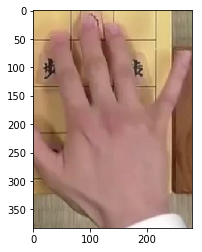

In [22]:
plt.imshow(img_skelton)

#### 画像を明るくする

In [145]:
def gamma_convert(img, gamma):
    lookUpTable = np.zeros((256, 1), dtype = 'uint8')

    for i in range(256):
        lookUpTable[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)
        
    img_g = cv2.LUT(img, lookUpTable)
    return img_g

In [146]:
img_list = [gamma_convert(img_hand_um, 0.08 * i) for i in range(10, 31)]

In [147]:
img_detect_list = [draw_hand_keypoints(img, hand_detector(img, hand_type="right"), (0,0)) for img in img_list]

In [148]:
len(img_detect_list)

21

In [149]:
def compare_plot(imgs, labels, cmaps=None):
    """
    複数画像を比較して出力する際に使用
    
    imgs : 複数画像を含んだリスト
    labels : 画像のラベルを含んだリスト
    cmaps : 画像の出力形式を含んだリスト(チャンネルが1の際に使用)
    """
    fig, ax = plt.subplots(1, len(labels), figsize=(6*len(labels),6))

    for i, im in enumerate(imgs):
        if len(im.shape) == 3:
            ax[i].imshow(im)
        else:
            ax[i].imshow(im, cmap=cmaps[i])
        ax[i].set_title(labels[i])
    plt.show()

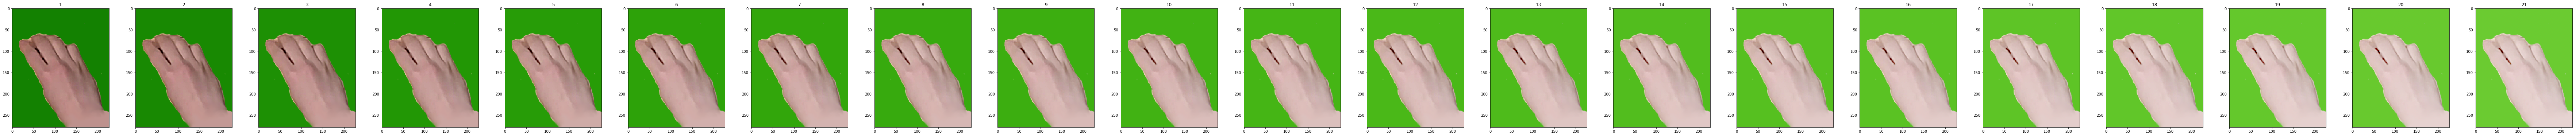

In [150]:
compare_plot(img_detect_list, [_ for _ in range(1,22)])

In [70]:
hand_keypoints = hand_detector(img_hand_g, hand_type="right")

NameError: name 'img_hand_g' is not defined

In [ ]:
img_skelton = draw_hand_keypoints(img_hand_g, hand_keypoints, (0,0))

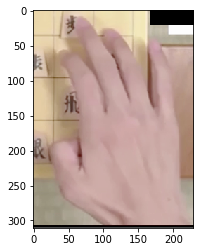

In [211]:
plt.imshow(img_skelton)

In [138]:
hand_keypoints = hand_detector(field, hand_type="right")

In [139]:
img_skelton = draw_hand_keypoints(field, hand_keypoints, (0,0))

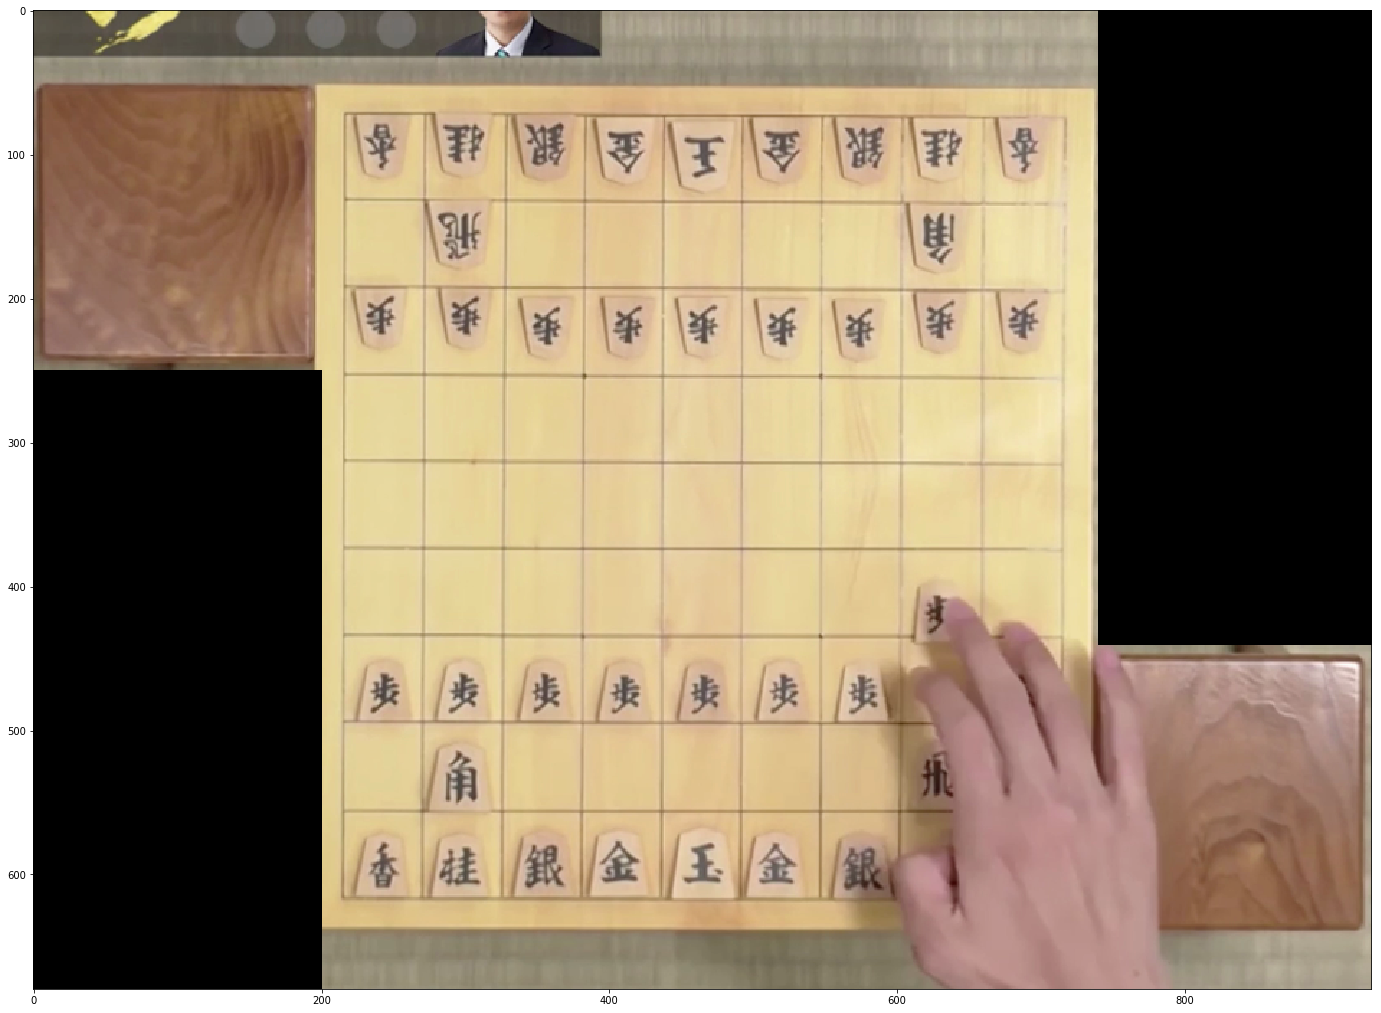

In [141]:
plt.figure(figsize=(30,18))
plt.imshow(img_skelton)

In [137]:
cv2.imwrite("hand_sample.png", cv2.cvtColor(img_hand, cv2.COLOR_RGB2BGR))

True

In [16]:
keypoints_dict = variables.keypoints_dict
get_parts_list = ["Nose","Neck","RShoulder","RElbow", "LShoulder", "LElbow", "REye", "LEye"]

## フレームごとにサンプリングしOpenPoseを適用

In [22]:
# 1秒ごとに計算させる
n_frame = 6
player1, player2 = [], []
output_path = "/media/nvidia/ST_USB32G/output/"

frame_all = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = [_ for _ in range(frame_all) if _%n_frame == 0]


for idx in tqdm(frame_idx):  
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    _, frame = cap.read()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (0, 0), (600, 100), (0, 0, 0), -1)
    cv2.rectangle(img, (400, 120), (870, 650), (0, 0, 0), -1)

    keypoints, output_image = openpose.forward(img, True)
    
    try:
        player1.append(keypoints[0][[keypoints_dict[i] for i in get_parts_list]].ravel())
        player2.append(keypoints[1][[keypoints_dict[i] for i in get_parts_list]].ravel())
    except:
        print("player1,2 not detection")

    cv2.imwrite(os.path.join(output_path, "img/{0:06d}.png".format(idx)), cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

In [24]:
output_path = "/media/nvidia/ST_SD16G/Research/data/"

In [26]:
p1_df = pd.DataFrame(np.array(player1), \
        columns=["{}{}".format(parts, point) for parts in get_parts_list for point in ["_x", "_y", "_z"]])
p2_df = pd.DataFrame(np.array(player2), \
        columns=["{}{}".format(parts, point) for parts in get_parts_list for point in ["_x", "_y", "_z"]])

p1_df.to_csv(os.path.join(output_path, "player1_features_frame{}_v2.csv".format(n_frame)))
p2_df.to_csv(os.path.join(output_path, "player2_features_frame{}_v2.csv".format(n_frame)))

In [27]:
p1_df.head()

Nose_x      Nose_y    Nose_z       Neck_x      Neck_y    Neck_z  \
0  1074.120117  227.733719  0.976848  1099.547119  276.720032  0.863911   
1  1074.071777  227.723923  0.984512  1097.595093  276.715973  0.862189   
2  1074.052612  227.736115  0.989574  1097.570312  276.698975  0.868382   
3  1074.047729  227.750763  0.988936  1095.673706  276.697235  0.870513   
4  1074.021240  227.759781  0.987154  1095.675781  276.715546  0.864598   

   RShoulder_x  RShoulder_y  RShoulder_z     RElbow_x   ...    LShoulder_z  \
0  1042.826172   274.864227     0.898137  1029.007080   ...       0.829763   
1  1042.769775   274.879547     0.907020  1027.141602   ...       0.830836   
2  1042.761230   274.881134     0.903304  1027.173706   ...       0.834562   
3  1042.740845   274.878571     0.907569  1027.181885   ...       0.831546   
4  1042.733154   274.888123     0.907662  1027.162231   ...       0.828406   

      LElbow_x    LElbow_y  LElbow_z       REye_x      REye_y    REye_z  \
0  1150.425415  368.872162  0.552189  1087.842407  214.080902  0.967030   
1  1150.471069  368.770081  0.556024  1087.781616  214.069870  0.959511   
2  1150.553711  366.861176  0.564301  1087.765625  214.088974  0.952181   
3  1152.396973  366.864258  0.567580  1087.755371  214.110519  0.944013   
4  1150.543091  366.916168  0.563587  1087.735718  214.104477  0.939467   

   LEye_x  LEye_y  LEye_z  
0     0.0     0.0     0.0  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  
3     0.0     0.0     0.0  
4     0.0     0.0     0.0  

[5 rows x 24 columns]

In [28]:
p1_df.shape

(12446, 24)

In [11]:
df = pd.read_csv(os.path.join(output_path, "player2_features_v2.csv"), index_col=0)

In [12]:
df

Nose_x     Nose_y    Nose_z     Neck_x     Neck_y    Neck_z  \
0     266.97705  568.68360  0.839319  227.75848  580.38500  0.844021   
1     264.95007  568.59576  0.823604  227.79090  578.44430  0.847256   
2     257.21927  562.79500  0.854362  227.76057  576.48975  0.848225   
3     263.02370  570.49450  0.826759  225.74763  582.37036  0.849346   
4     270.83853  570.58070  0.869557  227.67761  584.30945  0.852729   
5     257.06770  568.68036  0.850298  223.81396  586.33580  0.858249   
6     241.39203  572.57280  0.915550  221.85124  580.40130  0.808145   
7     241.45828  578.42610  0.799537  221.88646  582.38810  0.815108   
8     243.43748  586.20210  0.792093  219.93079  584.26196  0.783192   
9     243.35889  588.29170  0.586065  221.84866  586.33570  0.853871   
10    255.17096  578.43930  0.396284  221.86472  588.28280  0.839069   
11    255.16423  588.21387  0.671676  225.75713  590.21400  0.827413   
12    257.09540  588.25070  0.612680  225.76959  596.05610  0.810999   
13    253.25792  586.30680  0.738574  225.69664  590.19680  0.864512   
14    257.20550  576.46860  0.673296  225.79454  588.18800  0.883353   
15    251.23824  572.60754  0.769365  225.70322  584.35090  0.855216   
16    249.32603  570.55853  0.774159  225.74457  580.38860  0.848631   
17    243.52888  558.82776  0.901533  223.81155  570.63340  0.879143   
18    241.46774  553.00354  0.906523  214.11840  562.76990  0.796531   
19    239.54850  554.88904  0.913012  215.99101  562.73660  0.795383   
20    241.41687  556.87665  0.850964  219.95236  562.79820  0.805526   
21    241.38367  556.94410  0.822342  219.91783  564.70620  0.798945   
22    243.48787  554.88245  0.923050  223.77829  564.69977  0.821891   
23    259.16354  554.89830  0.898822  227.70462  570.53217  0.895512   
24    259.19855  554.86017  0.888711  225.87338  568.66650  0.878974   
25    257.20044  552.91754  0.896530  225.86919  564.73883  0.861642   
26    251.26396  549.04270  0.826362  227.72230  562.74030  0.861807   
27    245.41846  554.81537  0.906636  227.68886  558.86755  0.864449   
28    245.41803  554.98580  0.930608  227.82274  558.90890  0.860109   
29    243.36716  554.96640  0.962061  227.66913  558.90466  0.867511   
...         ...        ...       ...        ...        ...       ...   
2460  214.07304  545.14640  0.890980  178.78352  558.85864  0.757072   
2461  212.18744  547.06670  0.908545  178.80066  556.90924  0.764361   
2462  212.11014  545.16990  0.934075  178.78154  556.87750  0.767561   
2463  223.79477  539.34174  0.936711  182.73071  554.97205  0.786504   
2464  227.83835  533.38370  0.864386  194.37021  547.08570  0.768377   
2465  239.52610  525.53394  0.726462  194.52350  539.32336  0.877497   
2466  243.51134  533.33910  0.753394  204.28212  539.21050  0.840571   
2467  272.73938  558.84375  0.814346  208.18044  556.83594  0.730071   
2468  259.15875  556.83570  0.890115  215.97112  554.87616  0.836276   
2469  257.19922  556.83750  0.845954  212.08324  554.84125  0.819334   
2470  261.12192  556.91490  0.857140  212.09933  554.97034  0.871759   
2471  266.96133  558.92680  0.807500  214.05086  556.85720  0.844788   
2472  268.89180  558.85815  0.820244  214.07529  556.84595  0.834069   
2473  263.02524  556.87050  0.846437  217.98419  554.97870  0.840943   
2474  243.47278  549.02985  0.786816  208.14085  549.03110  0.757125   
2475  223.80450  535.31060  0.870473  180.69945  554.99770  0.780616   
2476  210.11818  527.50080  0.912230  178.68416  547.08430  0.765283   
2477  184.66927  527.46500  0.817340  164.99721  541.16675  0.854238   
2478  155.25888  494.29916  0.813606  137.68344  525.51263  0.827774   
2479  151.33376  478.56564  0.881809  133.66312  513.76306  0.859631   
2480  178.77470  476.54477  0.757532  163.01704  507.96637  0.880158   
2481  192.41795  464.78134  0.894384  165.06130  509.82080  0.914191   
2482  219.95251  468.76425  0.836228  180.65524  511.83405  0.875886   
2483  251.28209  507.95023  0.895487  210.11044  